# 1. Setup

1.1 Install Dependencies
1.2 Import Dependencies
1.3 Set GPU Growth
1.4 Create Folder Structures

In [1]:
%pip install tensorflow opencv-python matplotlib

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
#import Standard Dependencies
import cv2
import os
import random 
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#import tensorflow dependencies - Functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [3]:
#1.4 create folder structures
#setup path
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [4]:
#create the Directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH) 

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# 2. Collect Positives and Anchors
2.1 Untar Labelled Faces in the Wild Dataset
2.2 Collect Positive and Anchor Classes

In [6]:
# http://vis.cs.umass.edu/lfw/

In [7]:
#uncompress Tar GZ Labelled Faces in the Wild Dataset
#!tar -xf lfw-funneled.tgz

In [8]:
#Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw_funneled'):
    for file in os.listdir(os.path.join('lfw_funneled', directory)):
        EX_PATH = os.path.join('lfw_funneled', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [9]:
#2.2 Collect Positive and Anchor Classes
#Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    #cut down frame to (250,250) pixels 
    frame = frame[120:120+250, 200:200+250, :]
    #show image back to screen
    cv2.imshow('Image Collection', frame)

    #breaking gracefully    
    if cv2.waitKey(2) & 0XFF == ord('q'):
        break
#release the webcam
cap.release()
#close the image show frame
cv2.destroyAllWindows()

In [10]:
frame.shape

(480, 640, 3)

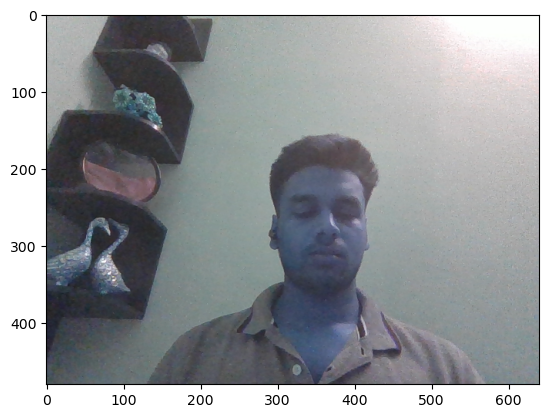

In [11]:
plt.imshow(frame)

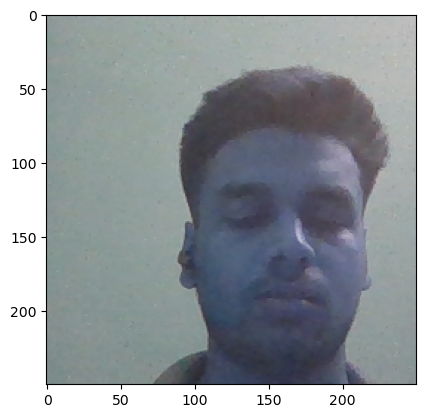

In [17]:
plt.imshow(frame[120:120+250, 200:200+250, :])

# 3.Load and Preprocess Images